In [3]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


## Figure 1

In [9]:
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
LR = 1
DECAY = np.exp(a+np.log(LR)*b)

In [10]:
print(DECAY)

495437.4241216812


In [3]:
nb_steps = 100000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]

params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 2.1
params['obj_rate'] = 3.44
LR = 10
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]
with_decay = True
with_plasticity = True
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True, with_plasticity=with_plasticity, with_decay=with_decay)
brunout = 5

dyn_fic = np.mean(fic_t, axis=1)
stat_fic = params['J']

FileNotFoundError: [Errno 2] No such file or directory: '../SC_and_5ht2a_receptors.mat'

Text(0.5, 1.0, 'Per region FIC comparison G=2.11 LR=10')

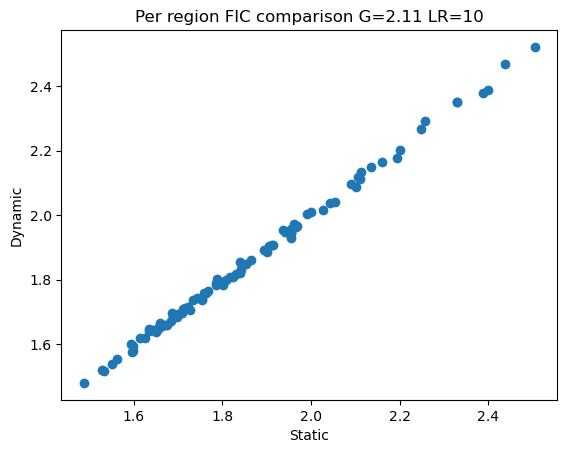

In [35]:
fig1a, axa1 = plt.subplots()
plt.scatter(stat_fic,dyn_fic,marker='o')
plt.xlabel("Static")
plt.ylabel("Dynamic")
plt.title("Per region FIC comparison G=2.11 LR=10")

## Figure 1.b


In [ ]:
nb_steps = 10000
C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
coeffs = loadmat('./Results/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
brunout = 5
params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 2.1
params['obj_rate'] = 3.44
LR = 10
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR

N = C.shape[0]
with_decay = True
with_plasticity = True
G_range = np.arange(0,16,0.25)
all_rates = np.zeros((2,len(G_range), 90))
for idx_G in range(len(G_range)):
    params['G'] = G_range[idx_G]
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    rates_dyn, r_ing,a,d = dmf.run(params, nb_steps,return_rate=True, return_bold=False, return_fic=False, with_plasticity=True, with_decay=True)
    rates_dyn = rates_dyn[:, np.ceil(brunout * 1000).astype(int):]
    rates_stat, r_ing,a,d = dmf.run(params, nb_steps,return_rate=True, return_bold=False, return_fic=False, with_plasticity=False, with_decay=False)
    rates_stat = rates_stat[:, np.ceil(brunout * 1000).astype(int):]
    all_rates[0,idx_G,:] = np.mean(rates_stat,1)
    all_rates[1,idx_G,:] = np.mean(rates_dyn,1)


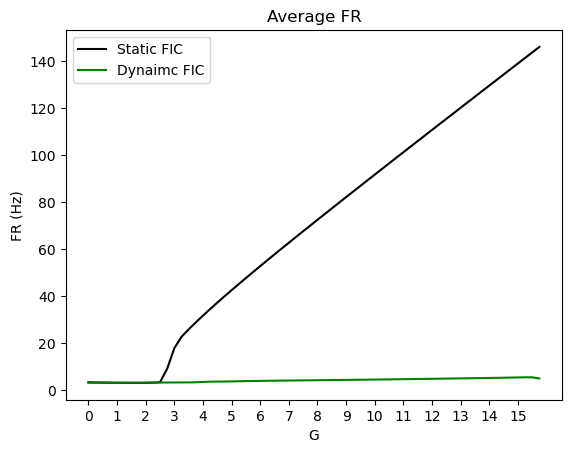

In [55]:
fig, ax = plt.subplots()
ax.plot(np.mean(all_rates, axis=2)[0], color='k', label='Static FIC')
ax.plot(np.mean(all_rates, axis=2)[1], color='g', label='Dynaimc FIC')

# Set x-axis tick labels from G_range
G_range = np.arange(0,16,0.25)
xtick_positions = range(0, len(G_range), 4)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([int(G_range[i]) for i in xtick_positions])

plt.title("Average FR")
plt.xlabel("G")
plt.ylabel("FR (Hz)")
plt.legend()


# Empirical fitting

In [3]:
data = np.squeeze(np.array(mat73.loadmat("data/BOLD_timeseries_HCP.mat")['BOLD_timeseries_HCP']))

In [4]:
data_struct = loadmat('./data/ts_coma24_AAL_symm_withSC.mat')

In [5]:
data = np.zeros((13,90,192))

In [6]:
data_struct['timeseries_CNT24_symm'][0][0].shape

(90, 192)

In [7]:
for i in range(13):
    data[i,:,:] = data_struct['timeseries_CNT24_symm'][0][i][:,:192]


In [8]:
#C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity']
C = data_struct['SC']

In [64]:


C = 0.2*C/np.max(C)
burnout = 5
coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]

params = dmf.default_params(C=C)
params['seed'] = 1
params['G'] = 4.0
params['obj_rate'] = 3.44
LR = 1.0
DECAY = np.exp(a+np.log(LR)*b)
params['taoj'] = DECAY
params['lrj'] = LR
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
params['TR'] = 2.4
T = 190
nb_steps = int((T-2*burnout)*params['TR']/params['dtt'])
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])
b,a = butter(2,np.array([0.01, 0.1])*2*params['TR'], btype='band')

In [65]:
params['with_decay'] = True
params['with_plasticity'] = True
params['return_bold'] = True
params['return_rate'] = True
params['return_fic'] = True
N = C.shape[0]
with_decay = True
with_plasticity = True
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps)

bold[:, (np.ceil(burnout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(burnout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(burnout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(burnout * 1000).astype(int):]
rates_fc = np.corrcoef(rates)
rates_inh_fc = np.corrcoef(rates_inh)
filt_bold = lfilter(b,a,bold)
time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc
bold_fc = np.corrcoef(filt_bold)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    reg_fic = fic_t[:, n]
    mean_fic_dist[n] = np.mean(reg_fic)

    

/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


    Using multitaper spectrum estimation with 30 DPSS windows


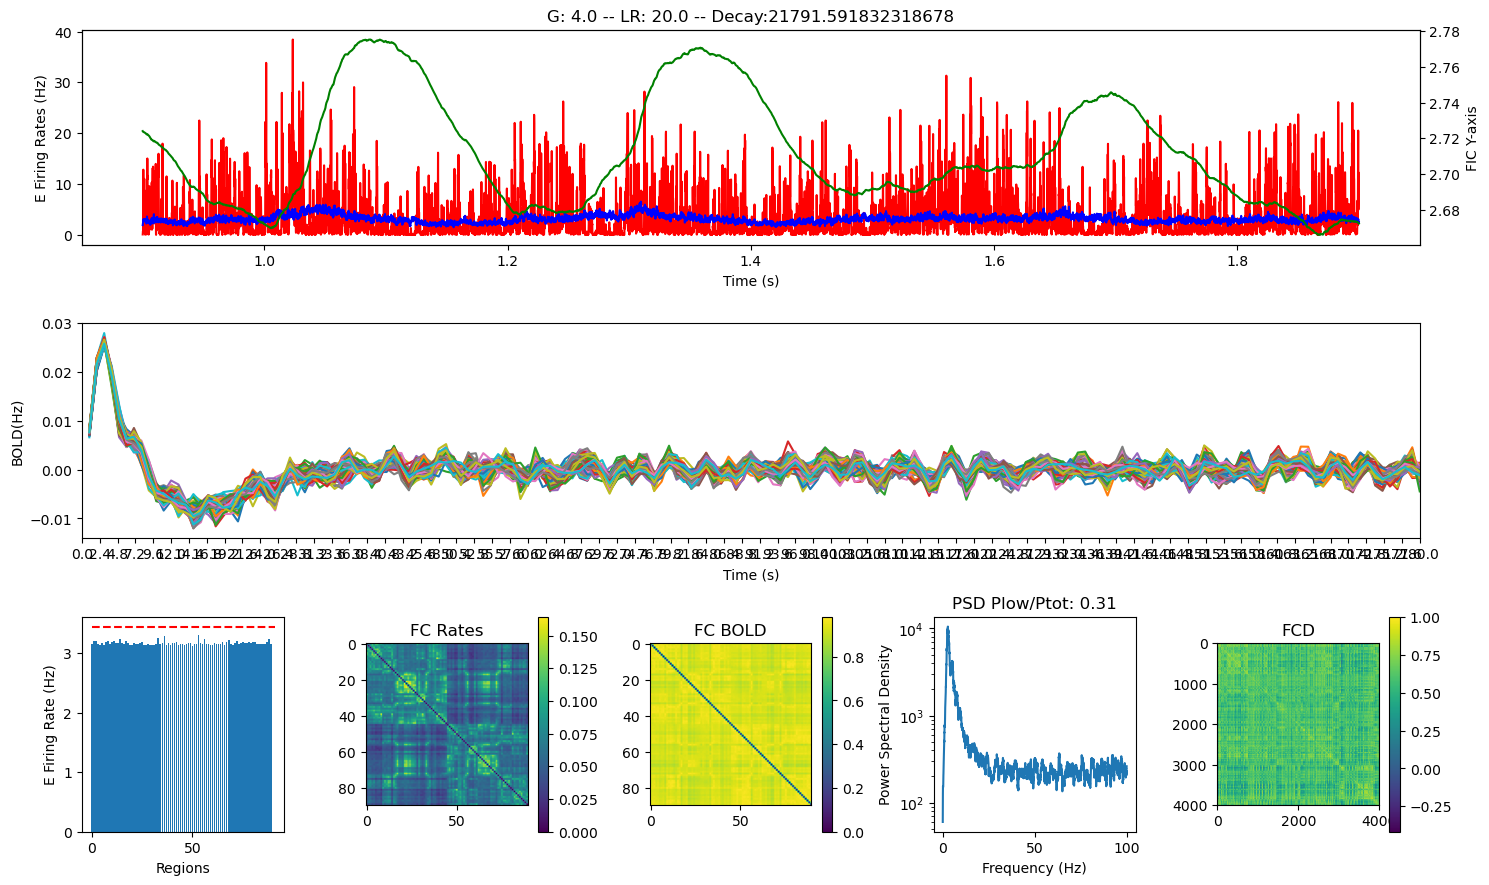

In [63]:
from mne.time_frequency import psd_array_multitaper
fig = plt.figure(figsize=(15, 9))
plt.axis('off')
#plt.title(f"G: {G_range[obs_idx_G]} -- LR: {LR_range[obs_idx_LR]}")
plt.title(f"G: {params['G']} -- LR: {params['lrj'] if with_plasticity else 'No plasticity '} -- Decay:{params['taoj'] if with_decay else 'No decay'}")

sel_t = np.arange(9000, 19000) #np.arange(1,rates.shape[1] +1 ) 
#sel_t = np.arange(1,rates.shape[1] +1 ) 
sel_t_bold = np.arange(1, bold.shape[1] + 1)

# Assuming 'rates' is your firing rates variable
sampling_freq = 10000  # Replace with your actual sampling frequency (e.g., 1000 Hz)
# Calculate the power spectral density using multitaper method
power_spectrum,frequencies = psd_array_multitaper(rates, sfreq=sampling_freq, fmin=0, fmax=100,bandwidth=32*(sampling_freq/rates.shape[1]))
four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)  

four_idx_freq = np.where(frequencies >= 4)[0][0]+1    
one_idx_freq = np.where(frequencies >= 1)[0][0]
plow_ptot = np.sum(power_spectrum[:, one_idx_freq:four_idx_freq], axis=1)/np.sum(power_spectrum[:,:], axis=1)                                        
slowest_reg = np.argmax(plow_ptot)


plt.subplot(3, 1, 1)
plt.plot(sel_t / 10000, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t / 10000, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t / 10000, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')


"""
plt.subplot(3, 1, 1)
plt.plot(sel_t / 10000, rates[slowest_reg,sel_t-1], 'r')
plt.plot(sel_t / 10000, np.mean(rates[:,sel_t-1], axis=0), 'b')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t / 10000, np.mean(fic_t[:,sel_t-1], axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')
"""

plt.subplot(3, 1,2)
plt.plot(sel_t_bold, filt_bold.T)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)

plt.semilogy(frequencies, power_spectrum[slowest_reg,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'PSD Plow/Ptot: {np.sum(power_spectrum[slowest_reg, one_idx_freq:four_idx_freq])/np.sum(power_spectrum[slowest_reg,:]):.2f}')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'homeostatic fittness')

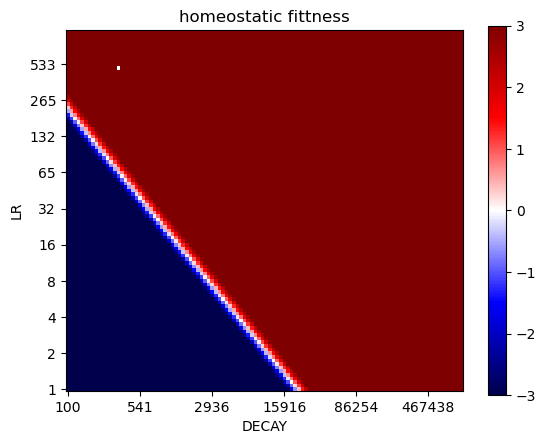

In [35]:
hom_grid = np.load('./Results/Figure1/HomeostaticFit3-44-Grid/mean_hom_fit_grid.npy')
LR_range = np.logspace(0,3,100)
DECAY_range = np.logspace(2,6,110)
normalized_hom_grid = (hom_grid-np.nanmean(hom_grid))
fig, ax = plt.subplots()
pos = ax.imshow(normalized_hom_grid.T, cmap='seismic', vmin=-3, vmax=3)
xtick_positions = range(0, len(DECAY_range), 20)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([f"{int(DECAY_range[i])}" for i in xtick_positions])
ax.set_xlabel("DECAY")
ytick_positions = range(0, len(LR_range), 10)
ax.invert_yaxis()
ax.set_yticks(ytick_positions)
ax.set_yticklabels([f"{int(LR_range[i])}" for i in ytick_positions])
ax.set_ylabel("LR")

fig.colorbar(pos, ax=ax)
plt.title("homeostatic fittness")


Text(0, 0.5, 'G')

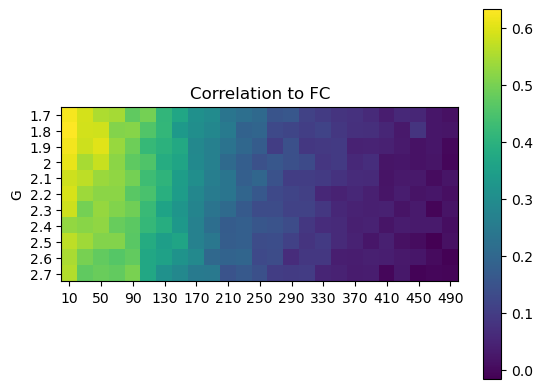

In [66]:
G_range = [1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7]#np.arange(0,G_max,G_step)
LR_range = np.arange(10,500,20)


fig, ax = plt.subplots()
pos = ax.imshow(fcs)


ytick_positions = range(0, len(G_range), 1)
ax.set_yticks(ytick_positions)
ax.set_yticklabels([G_range[i] for i in ytick_positions])

xtick_positions = range(0, len(LR_range), 2)
ax.set_xticks(xtick_positions)
ax.set_xticklabels([int(LR_range[i]) for i in xtick_positions])


fig.colorbar(pos, ax=ax)
plt.title("Correlation to FC")
plt.ylabel("G")




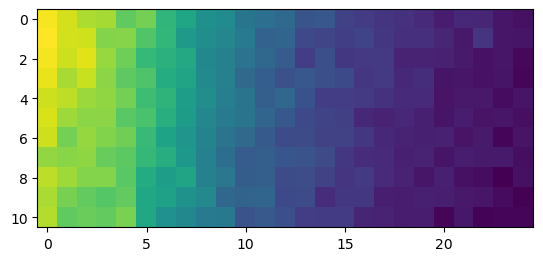

In [53]:
plt.imshow(fcs)

Doing 7.97747848751095 4.730229437354636


/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Doing 1.024995583434854 4.99616206129658
Doing 0.14110852616214056 1.005525898448607
Doing 7.945435643124202 3.7841345878344126


/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ivan.mindlin/anaconda3/envs/fic/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value e

Doing 2.562940597998343 1.077918978494763


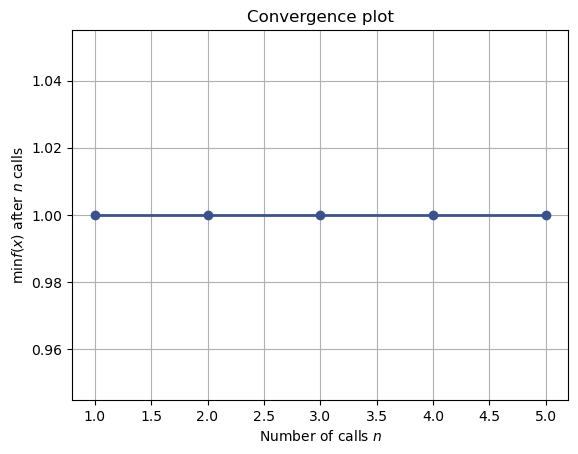

In [72]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
import pickle as pkl
from skopt import gp_minimize
from joblib import Parallel, delayed
from skopt.plots import plot_convergence
#from mne.time_frequency import psd_array_multitaper

MODEL_TYPE = "dynamic"
folder_path = f"./Results/fit_coma_cnt_bayesian/{MODEL_TYPE}/"

def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd

data_struct = loadmat('./data/ts_coma24_AAL_symm_withSC.mat')
data = np.zeros((13,90,192))
for i in range(13):
    data[i,:,:] = data_struct['timeseries_CNT24_symm'][0][i][:,:192]

C = loadmat('data/SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
params['N'] = len(C)
# Main setup for this simulation
params["return_rate"] = True
params["return_bold"] = True
params["return_fic"] = True
# These are now default true
params["with_plasticity"] = True
params["with_decay"] = True


burnout = 5
flp = 0.01
fhp = 0.1
b_filter,a_filter = butter(2,np.array([flp, fhp])*2*params['TR'], btype='band')
wsize = 30
overlap = 29
T = 192 - burnout
win_start = np.arange(0, T - wsize - 1, wsize - overlap)
nwins = len(win_start)
isubfc = np.triu_indices(C.shape[1],1)
nints = len(isubfc[0])
isubfcd = np.triu_indices(nwins,1)
NSUB = 13
emp_fcds = np.zeros((NSUB,nwins,nwins))
emp_fcs = np.zeros((NSUB,params['N'],params['N']))



for i in range(NSUB):
    bold = data[i]
    bold = bold[:, burnout:]    
    filt_bold = lfilter(b_filter,a_filter,bold)
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfc)    
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc.T)       
    emp_fcds[i] = fcd
    emp_fcs[i] = bold_fc

coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
params['N'] = C.shape[0]
params['TR'] = 2.4
nb_steps = int((data.shape[-1]-burnout)*params['TR']/params['dtt'])


# Define the number of cores to use
NUM_CORES = 24

def parallelized_function(rep, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc):
    _, _, bold, _ = dmf.run(params, nb_steps)         
    filt_bold = lfilter(b_filter, a_filter, bold)
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfc)
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc.T)
    return bold_fc, fcd

def run_parallel(NSUB, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc):
    sim_fcs = Parallel(n_jobs=NSUB)(delayed(parallelized_function)(rep, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc) for rep in range(NSUB))
    return sim_fcs


def dmf_step_dyn(args):
    sim_fcds = np.zeros((NSUB,nwins,nwins))
    sim_fcs = np.zeros((NSUB,params['N'],params['N']))
    G, LR = args    
    print(f"Doing {G} {LR}")
    DECAY = np.exp(a+np.log(LR)*b)
    OBJ_RATE = 3.44    
    params['lrj'] = LR
    params['G'] = G
    # Using heuristic linear rule 
    params['taoj'] = DECAY 
    params['obj_rate'] = OBJ_RATE    
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params['with_decay'] = True
    params['with_plasticity]'] = True
    parallel_results = run_parallel(NSUB, params, nb_steps, burnout, params['TR'], b_filter, a_filter, wsize, overlap, isubfc)
    for rep in range(len(parallel_results)):
        sim_fcs[rep,:,:] = parallel_results[rep][0]
        sim_fcds[rep,:,:] = parallel_results[rep][1]
    
    crashed = np.isnan(np.mean(sim_fcs,axis=0)).any()
    mean_fc = np.mean(sim_fcs,axis=0) if not crashed else np.zeros((params['N'],params['N']))        

    corr_to_sc = 0 if crashed else pearsonr(mean_fc[isubfc[0],isubfc[1]], np.mean(emp_fcs,axis=0)[isubfc[0],isubfc[1]])[0]              
    ks, p = 1, 1 if crashed else ks_2samp(sim_fcds[:,isubfcd[0],isubfcd[1]].flatten(),emp_fcds[:,isubfcd[0],isubfcd[1]].flatten())        
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)    
    filename = f"mean-fc.txt"    
    file_path = os.path.join(folder_path, filename)    
    np.savetxt(file_path, mean_fc)

    filename = f"corr-to-sc.txt"    
    file_path = os.path.join(folder_path, filename)    
    with open(file_path, 'w') as file:
        file.write(str(corr_to_sc))

    filename = f"ks.txt"    
    file_path = os.path.join(folder_path, filename)    
    with open(file_path, 'w') as file:
        file.write(str(ks))
    
    return ks



def intermediate_save(res):
    
    # Load mean-fc.txt
    filename_mean_fc = "mean-fc.txt"
    file_path_mean_fc = os.path.join(folder_path, filename_mean_fc)
    mean_fc = np.loadtxt(file_path_mean_fc)
    # Load corr-to-sc.txt
    filename_corr_to_sc = "corr-to-sc.txt"
    file_path_corr_to_sc = os.path.join(folder_path, filename_corr_to_sc)
    with open(file_path_corr_to_sc, 'r') as file:
        corr_to_sc = float(file.read())
    
    file_path = os.path.join(folder_path, "best_result.txt")

    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, load the previous best result
        with open(file_path, 'r') as file:
            best_result = float(file.read())

        # Compare with the current result and update if necessary
        if res.fun < best_result:
            with open(file_path, 'w') as file:
                file.write(str(res.fun))
            iter_folder_path = os.path.join(folder_path, f"iter_{len(res.x_iters)}")
            if not os.path.exists(iter_folder_path):
               os.makedirs(iter_folder_path)   
            filename = f"mean-fc.txt"    
            file_path = os.path.join(iter_folder_path, filename)    
            np.savetxt(file_path, mean_fc)

            filename = f"corr-to-sc.txt"    
            file_path = os.path.join(iter_folder_path, filename)    
            with open(file_path, 'w') as file:
                file.write(str(corr_to_sc))

            filename = f"res.pkl"    
            file_path = os.path.join(iter_folder_path, filename)    
            with open(file_path, 'wb') as file:
                pkl.dump(res,file)

    else:
        # If the file doesn't exist, create it and save the current result
        with open(file_path, 'w') as file:
            file.write(str(res.fun))
        iter_folder_path = os.path.join(folder_path, f"iter_{len(res.x_iters)}")
        if not os.path.exists(iter_folder_path):
            os.makedirs(iter_folder_path)   
        filename = f"mean-fc.txt"    
        file_path = os.path.join(iter_folder_path, filename)    
        np.savetxt(file_path, mean_fc)

        filename = f"corr-to-sc.txt"    
        file_path = os.path.join(iter_folder_path, filename)    
        with open(file_path, 'w') as file:
            file.write(str(corr_to_sc))

        filename = f"res.pkl"    
        file_path = os.path.join(iter_folder_path, filename)    
        with open(file_path, 'wb') as file:
            pkl.dump(res,file)



G_range = (1.0, 8.0)
LR_range = (1.0,1000.0)

res = gp_minimize(dmf_step_dyn,
                  [G_range,LR_range],
                  acq_func="EI",      # the acquisition function
                  n_calls=5,         # the number of evaluations of f
                  n_random_starts=2,  # the number of random initialization points
                  noise=1e-10,       # the noise level (optional)
                  random_state=1,
                  callback=intermediate_save,
                  n_jobs=-1)



plot_convergence(res)
plot_file = os.path.join(folder_path, "convergence.png")
plt.savefig(plot_file)

In [137]:
filename = os.path.join(folder_path, "iter_1/res.pkl")
with open(filename, 'rb') as f:
    res5 = pkl.load(f)

In [10]:
from scipy.signal import butter, lfilter
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import os
import pickle as pkl
from skopt import gp_minimize
from joblib import Parallel, delayed
from skopt.plots import plot_convergence
#from mne.time_frequency import psd_array_multitaper

MODEL_TYPE = "static"
folder_path = f"./Results/fit_coma_cnt_bayesian/{MODEL_TYPE}/"

def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd

data_struct = loadmat('./data/ts_coma24_AAL_symm_withSC.mat')
data = np.zeros((13,90,192))
for i in range(13):
    data[i,:,:] = data_struct['timeseries_CNT24_symm'][0][i][:,:192]

C = loadmat('data/SC_and_5ht2a_receptors.mat')['sc90']
C = 0.2*C/np.max(C)
params = dmf.default_params(C=C)
params['N'] = len(C)
# Main setup for this simulation
params["return_rate"] = True
params["return_bold"] = True
params["return_fic"] = True
# These are now default true
params["with_plasticity"] = False
params["with_decay"] = False


burnout = 5
flp = 0.01
fhp = 0.1
b_filter,a_filter = butter(2,np.array([flp, fhp])*2*params['TR'], btype='band')
wsize = 30
overlap = 29
T = 192 - burnout
win_start = np.arange(0, T - wsize - 1, wsize - overlap)
nwins = len(win_start)
isubfc = np.triu_indices(C.shape[1],1)
nints = len(isubfc[0])
isubfcd = np.triu_indices(nwins,1)
NSUB = 13
emp_fcds = np.zeros((NSUB,nwins,nwins))
emp_fcs = np.zeros((NSUB,params['N'],params['N']))



for i in range(NSUB):
    bold = data[i]
    bold = bold[:, burnout:]    
    filt_bold = lfilter(b_filter,a_filter,bold)
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfc)    
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc.T)       
    emp_fcds[i] = fcd
    emp_fcs[i] = bold_fc

coeffs = loadmat('./data/LinearFitCoefficients.mat')
a = coeffs['a'][0][0]
b = coeffs['b'][0][0]
params['N'] = C.shape[0]
params['TR'] = 2.4
nb_steps = int((data.shape[-1]-burnout)*params['TR']/params['dtt'])


# Define the number of cores to use
NUM_CORES = 24

def parallelized_function(rep, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc):
    _, _, bold, _ = dmf.run(params, nb_steps)         
    filt_bold = lfilter(b_filter, a_filter, bold)
    time_fc = compute_fcd(filt_bold.T, wsize, overlap, isubfc)
    bold_fc = np.corrcoef(filt_bold)
    fcd = np.corrcoef(time_fc.T)
    return bold_fc, fcd

def run_parallel(NSUB, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc):
    sim_fcs = Parallel(n_jobs=NSUB)(delayed(parallelized_function)(rep, params, nb_steps, burnout, TR, b_filter, a_filter, wsize, overlap, isubfc) for rep in range(NSUB))
    return sim_fcs


def dmf_step_dyn(args):
    sim_fcds = np.zeros((NSUB,nwins,nwins))
    sim_fcs = np.zeros((NSUB,params['N'],params['N']))
    G, ALPHA = args    
    print(f"Doing {G} {ALPHA}")    
    OBJ_RATE = 3.44        
    params['G'] = G
    # Using heuristic linear rule     
    params['obj_rate'] = OBJ_RATE    
    params['alpha'] = ALPHA
    params['J'] = ALPHA*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params['with_decay'] = False
    params['with_plasticity]'] = False
    params['seed']=1
    parallel_results = run_parallel(NSUB, params, nb_steps, burnout, params['TR'], b_filter, a_filter, wsize, overlap, isubfc)
    for rep in range(len(parallel_results)):
        sim_fcs[rep,:,:] = parallel_results[rep][0]
        sim_fcds[rep,:,:] = parallel_results[rep][1]
    
    crashed = np.isnan(np.mean(sim_fcs,axis=0)).any()
    mean_fc = np.mean(sim_fcs,axis=0) if not crashed else np.zeros((params['N'],params['N']))        

    #corr_to_sc = 0 if crashed else pearsonr(mean_fc[isubfc[0],isubfc[1]], np.mean(emp_fcs,axis=0)[isubfc[0],isubfc[1]])[0]
    corr_to_sc = 0 if crashed else np.corrcoef(mean_fc[isubfc[0],isubfc[1]], np.mean(emp_fcs,axis=0)[isubfc[0],isubfc[1]])              
    ks, p = 1, 1 if crashed else ks_2samp(sim_fcds[:,isubfcd[0],isubfcd[1]].flatten(),emp_fcds[:,isubfcd[0],isubfcd[1]].flatten())    
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)    
    filename = f"mean-fc.txt"    
    file_path = os.path.join(folder_path, filename)    
    np.savetxt(file_path, mean_fc)

    filename = f"corr-to-sc.txt"    
    file_path = os.path.join(folder_path, filename)    
    with open(file_path, 'w') as file:
        file.write(str(corr_to_sc))

    filename = f"ks.txt"    
    file_path = os.path.join(folder_path, filename)    
    with open(file_path, 'w') as file:
        file.write(str(ks))
    """    
    # CAMBIAR
    return 1-corr_to_sc



def intermediate_save(res):
    
    # Load mean-fc.txt
    filename_mean_fc = "mean-fc.txt"
    file_path_mean_fc = os.path.join(folder_path, filename_mean_fc)
    mean_fc = np.loadtxt(file_path_mean_fc)
    # Load corr-to-sc.txt
    filename_corr_to_sc = "corr-to-sc.txt"
    file_path_corr_to_sc = os.path.join(folder_path, filename_corr_to_sc)
    with open(file_path_corr_to_sc, 'r') as file:
        corr_to_sc = float(file.read())
    
    file_path = os.path.join(folder_path, "best_result.txt")

    # Check if the file exists
    if os.path.exists(file_path):
        # If the file exists, load the previous best result
        with open(file_path, 'r') as file:
            best_result = float(file.read())

        # Compare with the current result and update if necessary
        if res.fun < best_result:
            with open(file_path, 'w') as file:
                file.write(str(res.fun))
            iter_folder_path = os.path.join(folder_path, f"iter_{len(res.x_iters)}")
            if not os.path.exists(iter_folder_path):
               os.makedirs(iter_folder_path)   
            filename = f"mean-fc.txt"    
            file_path = os.path.join(iter_folder_path, filename)    
            np.savetxt(file_path, mean_fc)

            filename = f"corr-to-sc.txt"    
            file_path = os.path.join(iter_folder_path, filename)    
            with open(file_path, 'w') as file:
                file.write(str(corr_to_sc))

            filename = f"res.pkl"    
            file_path = os.path.join(iter_folder_path, filename)    
            with open(file_path, 'wb') as file:
                pkl.dump(res,file)

    else:
        # If the file doesn't exist, create it and save the current result
        with open(file_path, 'w') as file:
            file.write(str(res.fun))
        iter_folder_path = os.path.join(folder_path, f"iter_{len(res.x_iters)}")
        if not os.path.exists(iter_folder_path):
            os.makedirs(iter_folder_path)   
        filename = f"mean-fc.txt"    
        file_path = os.path.join(iter_folder_path, filename)    
        np.savetxt(file_path, mean_fc)

        filename = f"corr-to-sc.txt"    
        file_path = os.path.join(iter_folder_path, filename)    
        with open(file_path, 'w') as file:
            file.write(str(corr_to_sc))

        filename = f"res.pkl"    
        file_path = os.path.join(iter_folder_path, filename)    
        with open(file_path, 'wb') as file:
            pkl.dump(res,file)



G_range = (1.5, 3.0)
ALPHA_range = (0.5,1.0)
"""
#res = gp_minimize(dmf_step_dyn,
                  [G_range,ALPHA_range],
                  acq_func="EI",      # the acquisition function
                  n_calls=20,         # the number of evaluations of f
                  n_initial_points=2,  # the number of random initialization points
                  noise=1e-10,       # the noise level (optional)
                  random_state=1,
                  x0=[[2.1, 0.75], [1.9,0.8]],
                  callback=intermediate_save,
                  n_jobs=-1)
"""


#plot_convergence(res)
#plot_file = os.path.join(folder_path, "convergence.png")
#plt.savefig(plot_file)

'\n#res = gp_minimize(dmf_step_dyn,\n                  [G_range,ALPHA_range],\n                  acq_func="EI",      # the acquisition function\n                  n_calls=20,         # the number of evaluations of f\n                  n_initial_points=2,  # the number of random initialization points\n                  noise=1e-10,       # the noise level (optional)\n                  random_state=1,\n                  x0=[[2.1, 0.75], [1.9,0.8]],\n                  callback=intermediate_save,\n                  n_jobs=-1)\n'

In [8]:
corr_to_fc = dmf_step_dyn((2.1, 0.75))

Doing 2.1 0.75


In [9]:
corr_to_fc

array([[0.00000000e+00, 2.30726492e-01, 5.17895400e-01, ...,
        1.44387517e+00, 1.22882804e+00, 8.32962986e-01],
       [2.30726492e-01, 0.00000000e+00, 2.67812921e-01, ...,
        1.26942538e+00, 1.02084126e+00, 1.08122936e+00],
       [5.17895400e-01, 2.67812921e-01, 0.00000000e+00, ...,
        1.05032831e+00, 1.09776014e+00, 1.26175214e+00],
       ...,
       [1.44387517e+00, 1.26942538e+00, 1.05032831e+00, ...,
        2.22044605e-16, 4.61393901e-01, 1.47859289e+00],
       [1.22882804e+00, 1.02084126e+00, 1.09776014e+00, ...,
        4.61393901e-01, 0.00000000e+00, 1.07906063e+00],
       [8.32962986e-01, 1.08122936e+00, 1.26175214e+00, ...,
        1.47859289e+00, 1.07906063e+00, 0.00000000e+00]])

In [85]:
res

          fun: 0.7103595371312051
            x: [1.5, 0.6371604828966725]
    func_vals: [ 7.464e-01  7.728e-01 ...  7.792e-01  8.833e-01]
      x_iters: [[2.1, 0.75], [1.9, 0.8], [2.995777216408303, 0.9662786796693295], [1.692186671894035, 0.9995202576620725], [1.5, 0.6670586774044188], [3.0, 0.553514709023214], [1.5, 0.7208469906300529], [1.7174248681240731, 0.5], [2.07147316545535, 0.6807155389797708], [1.5, 0.5161879600676905], [2.47939543959272, 0.7812814673996575], [1.5, 0.6371604828966725], [3.0, 0.8469750770770271], [1.5, 0.6129471640603308], [1.5, 0.8810757997384205], [3.0, 0.746569788562518], [2.35317640707632, 0.8409863298195352], [1.684378053249342, 0.6362698734456175], [1.5, 0.7827691445755685], [2.3469076384460905, 0.5]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1e-10),
                                        n_restarts_optimizer=2, noise=1e-10, normalize_y=True,
                                  

In [15]:
import pickle as pkl

with open('./Results/fit_coma_cnt_bayesian/static_fc-1/iter_141/res.pkl', 'rb') as f:
    res_fc_static = pkl.load(f)

In [18]:
static_fc = np.loadtxt('./Results/fit_coma_cnt_bayesian/static_fc-1/iter_141/mean-fc.txt')

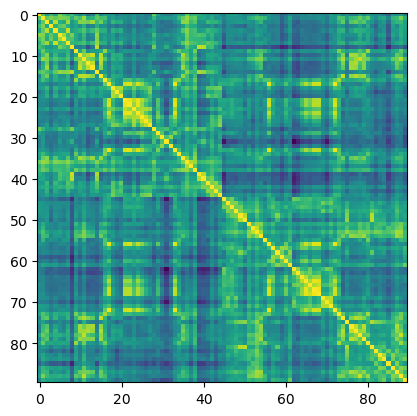

In [20]:
plt.imshow(static_fc)

In [16]:
res_fc_static

          fun: 0.710507500334492
            x: [1.497166913566268, 0.6365063088594731]
    func_vals: [ 8.503e-01  8.582e-01 ...  8.066e-01  7.105e-01]
      x_iters: [[7.97747848751095, 0.9332317857452724], [1.024995583434854, 0.9990501101709035], [1.888711815615809, 0.402614920023066], [3.10328592929606, 0.6730485764354454], [7.484312566448256, 0.8478478075191571], [2.5061881354582014, 0.5293026779771428], [3.547623150236454, 0.23728144159252734], [4.275311271576137, 0.9148224043334409], [3.657638463895907, 0.4363915815128615], [7.513022315389008, 0.7806053439731684], [8.0, 0.9817928088616298], [7.958939833779107, 0.8921302670860652], [7.943560271205034, 0.8568932078571484], [8.0, 0.9000406230782223], [6.577157758369891, 0.8931223458869233], [1.5571398670487269, 0.9718021323946086], [4.210905494260148, 0.9553688118879103], [0.0, 0.9797528021438413], [7.502848184048469, 0.8946902392360264], [2.333656116387513, 0.9885775651608597], [6.995008053451788, 0.9143524909356109], [1.837582546